# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [63]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [86]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
sw = set(sw)

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    
    # finding total number of tokens by the length of tokens list
    num_tokens = len(tokens)
    
    # creating a set of tokens to find unique, and then length of that
    num_unique_tokens = len(set(tokens))
    
    # dividing unique over total to find diversity
    lexical_diversity = num_unique_tokens / num_tokens
    
    
    # creating a quick for-loop to cound all characters in document
    num_characters_list = []
    for word in tokens:
        num_characters_list.append(len(word))
        
    num_characters = sum(num_characters_list)
    
    # utilizing Counter to count the characters and then finding the top 5
    
    common_count = Counter(tokens)
    
    most_common_five = common_count.most_common(5)
    
    if verbose == True:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"These are the five most common tokens and their count:\n {most_common_five}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, most_common_five])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

    
def remove_stop(tokens) :
    
    return [t for t in tokens if t.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    text = text.split(' ') # split on whitespace to include hashtags and other information
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [66]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

# change `data_location` to the location of the folder on your machine.
data_location = "/Users/steph/OneDrive/Documents/USD/ADS509/Mod2/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}
artist_folder = ['cher/', 'robyn/']


In [67]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [68]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [69]:
# read in the lyrics here

# reading in lyric data
# this for cher and Robyn data

lyric_path = data_location + lyrics_folder

lyric_dict_cr = {"artist": [], "song_name": [], "lyrics": []}

for artist_folder in os.listdir(lyric_path):
    artist_path = lyric_path + artist_folder
    for file in os.listdir(artist_path):
        if file.endswith(".txt"):
            file_path = f"{artist_path}/{file}"
            with open(file_path, 'r') as f:
                lyrics = f.read()
                song_name = file.split("_")[1].split(".")[0] # take just song title from file name
                
                # adding data to dictionary
                lyric_dict_cr['artist'].append(artist_folder)
                lyric_dict_cr['song_name'].append(song_name)
                lyric_dict_cr['lyrics'].append(lyrics)
                

lyrics_data = pd.DataFrame(lyric_dict_cr)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [70]:
print(lyrics_data['lyrics'].sample(8))

131    "It's Too Late To Love Me Now"\n\n\n\nIt's too...
340    "Dancing On My Own"\n\n\n\nSomebody said you g...
96     "Holy Smoke"\n\n\n\nWhere do we draw the line ...
287    "We All Sleep Alone"\n\n\n\nSomebody, somewher...
226    "(Sittin' On) The Dock Of The Bay"\n\n\n\nSitt...
61     "Do You Believe In Magic"\n\n\n\nDo you believ...
91     "He'll Never Know"\n\n\n\nThey go off and leav...
231    "Spring"\n\n\n\nIn a broken down apartment hou...
Name: lyrics, dtype: object


In [71]:
print(twitter_data['description'].sample(8))

916020                                                   NaN
2951104                               Hey muther fuckers !:D
529279              i'm like a jigglypuff with some problems
299277     i love justin! im very out goin and im related...
3328535                                                  NaN
1718845              Love once ❤ Enjoy it Live once Enjoy it
185798                       Mi Gusta Dexter #TeamFollowBack
2602141                                                  NaN
Name: description, dtype: object


Need to get rid of the \n's in lyric data; as well as the title of each song, before sending through our pipeline

In [72]:
r = re.compile(r'(\n)+')

lyrics_data['lyrics'] = [r.sub(' ', txt) for txt in lyrics_data['lyrics']]

In [74]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [88]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [89]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","tokens"]]

,artist,tokens
151029,cher,"[pretty, little, birds, 🕊]"
985025,cher,"[christina, 29, sheher, talking, exclusively, ..."
869529,cher,"[🌺passionate, development, , positive, changef..."
1170224,cher,[lchs🐻✨]
2702645,cher,"[makeup, beautiful, every, way, 💄slay, day💁]"
3296240,cher,"[31, salford, #mufc, 🔴⚪⚫]"
3942212,cher,"[freelance, video, journalist, , blogger, 📹, s..."
681885,cher,"[forget, regret, life, miss✌️]"
1005339,cher,"[pgh, ➡️, sea, , sheher, , black, lives, matte..."
1945942,cher,"[🏳️‍🌈take, another, little, piece, heart, baby..."


With the data processed, we can now start work on the assignment questions. 

#### Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: For the twitter descriptions, I've noticed there are different languages used. Perhaps, there can be a way to remove stopwords in other languages, or try to translate everything to one language (english, presumably). When users use emojis, there's often no spaces in between, thus, our pipeline did not tokenize them or make them separate. So tokenizing them would be an improvement.

Another example I've seen is the MWET tokenizer that can allow some multi-word expressions and into can turn those into single tokens, like a multiword title to something. For example, the movie Top Gun -- it would have two separate tokens of ['top','gun'] would be changed to ['top_gun'] to know it was the movie rather than someone using the words top and gun separately.

Another addition, after seeing the top words in the next section, is if we can remove the stop words prior to remove punctuation. I know there are some words like "don't" in stop words; and if we remove punctuation first, "dont" will not get removed when it comes time for that.

Finally, within the lyrics, oftentimes there are words signifying the part of the song like "Chorus" or "Verse" -- these are contained in nearly every song, so these should be taken out as well.


## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [102]:
# your code here

twit_tokens = twitter_data[twitter_data.has_emoji]['tokens']

twit_tokens = [i for sublist in twit_tokens for i in sublist]

# getting rid of blank entries
twit_tokens = [i for i in twit_tokens if i] # for some reason, other code was VERY slow for this


descriptive_stats(twit_tokens)

There are 3641987 tokens in the data.
There are 673656 unique tokens in the data.
There are 21132064 characters in the data.
The lexical diversity is 0.185 in the data.
These are the five most common tokens and their count:
 [('love', 37350), ('life', 21238), ('•', 20819), ('im', 17708), ('de', 16327)]


[3641987,
 673656,
 0.18496935875938053,
 21132064,
 [('love', 37350),
  ('life', 21238),
  ('•', 20819),
  ('im', 17708),
  ('de', 16327)]]

In [84]:
lyrics_tokens = [i for sublist in lyrics_data['tokens'] for i in sublist]

lyrics_tokens = [i for sublist in lyrics_tokens for i in sublist]

descriptive_stats(lyrics_tokens)

There are 51143 tokens in the data.
There are 4664 unique tokens in the data.
There are 246684 characters in the data.
The lexical diversity is 0.091 in the data.
These are the five most common tokens and their count:
 [('love', 1279), ('im', 812), ('know', 794), ('dont', 741), ('baby', 541)]


[51143,
 4664,
 0.09119527599084919,
 246684,
 [('love', 1279), ('im', 812), ('know', 794), ('dont', 741), ('baby', 541)]]

### Q: what observations do you make about these data? 

A: Some of the most common words in both are shared between artist and fan twitter description. "love" is the number one for each -- definitely a popular word to use in songs as well as in twitter description (I'd bet many are like "I love XYZ" with whatever their XYZ interests are); they may be used in different contexts though, like in twitter descriptions as a verb and as a noun in songs, as songs may use more the idea of love.

Another overlapped word is "im", which is another area that could have been tokenized better due to it being a contraction of I am. That would again make sense to be heavily used in both, especially as a combo of stop words. 

A word like 'baby' is another heavily used word in songs and makes sense to show up in lyrics, and not as often in twitter descriptions. There is also an emoji that is heavily used in twitter descriptions, and of course, that wouldn't be seen in lyrics.

In terms of uniqueness of data, there is, predictably, a much higher number of unique tokens in twitter description data, which makes sense due to the sheer number of tokens. However, even the lexical diversity is over 2x than the lyrics, so there is more often unique words than in the artists' lyrics.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [195]:
# testing out some code to run this whole function

tok_ex = "hello and hello there, my name is Stephen, and over there, what is your name? hello".split(" ")

count = Counter(tok_ex)
count_dict = {'token': [], 'corp_count': []}

for i in tok_ex:
    if i in count:
        if count[i] > 1:
            count_dict['token'].append(i)
            count_dict['corp_count'].append(count[i])
            
count_dict

{'token': ['hello',
  'and',
  'hello',
  'there,',
  'is',
  'and',
  'there,',
  'is',
  'hello'],
 'corp_count': [3, 2, 3, 2, 2, 2, 2, 2, 3]}

In [183]:
# writing function

def concentration_ratio(tokens1, tokens2):
    
    #getting total size of each corpus
    corp_size1 = len(tokens1)
    corp_size2 = len(tokens2)
    
    # creating dictionaries we will append to
    concentration_dict_1 = {'token': [], 'corp1_count': [], 'concentration_1': []}
    concentration_dict_2 = {'token': [], 'corp2_count': [], 'concentration_2': []}
    
    # getting counter dictionary of all 
    count_corp1 = Counter(tokens1)
    count_corp2 = Counter(tokens2) 
    
    for word in set(tokens1):
        if word in count_corp1:
            if count_corp1[word] >= 5: # cutoff of 5
                concentration_dict_1['token'].append(word)
                concentration_dict_1['corp1_count'].append(count_corp1[word])
                
                concentration_1 = (count_corp1[word] / corp_size1)
                
                concentration_dict_1['concentration_1'].append(concentration_1)
                
    for word in set(tokens2):
        if word in count_corp2:
            if count_corp2[word] >= 5: # cutoff of 5
                concentration_dict_2['token'].append(word)
                concentration_dict_2['corp2_count'].append(count_corp2[word])
                
                concentration_2 = count_corp2[word] / corp_size2
                
                concentration_dict_2['concentration_2'].append(concentration_2)
                
    concentration_df_1 = pd.DataFrame(concentration_dict_1)
    concentration_df_2 = pd.DataFrame(concentration_dict_2)
    
    # merging these together on token
    
    concentration_df = concentration_df_1.merge(concentration_df_2, on = 'token', suffixes = ('_lyr', '_twit'))
    
    # now creating ratio column
    concentration_df['ratio'] = concentration_df['concentration_1'] / concentration_df['concentration_2']
    
    return concentration_df
            
            

In [184]:
# running and saving df

concentration_df = concentration_ratio(lyrics_tokens, twit_tokens)

In [188]:
# Looking at the top 10 tokens in terms of much higher lyric concentration vs twitter concentration

concentration_df.sort_values(by = 'ratio', ascending = False).head(10)

,token,corp1_count,concentration_1,corp2_count,concentration_2,ratio
1308,chorus,117,0.002288,15,0.000004,555.452332
577,cryin,32,0.000626,5,0.000001,455.755759
1282,digi,32,0.000626,7,0.000002,325.539828
516,waterloo,21,0.000411,6,0.000002,249.241431
1015,ooh,73,0.001427,23,0.000006,226.020180
988,runnin,28,0.000547,9,0.000002,221.547939
337,whoa,14,0.000274,5,0.000001,199.393145
648,jaw,14,0.000274,6,0.000002,166.160954
458,dancehall,16,0.000313,8,0.000002,142.423675
1195,cadillac,10,0.000196,5,0.000001,142.423675


In [189]:
# And Looking at the top 10 tokens in terms of much higher twitter concentration vs lyric concentration

concentration_df.sort_values(by = 'ratio').head(10)

,token,corp1_count,concentration_1,corp2_count,concentration_2,ratio
100,lover,11,0.000215,13915,0.003821,0.056294
115,family,6,0.000117,5724,0.001572,0.074646
1110,wife,8,0.000156,6804,0.001868,0.083729
1229,en,7,0.000137,5827,0.001600,0.085547
789,2,7,0.000137,4952,0.001360,0.100663
911,mi,5,0.000098,3491,0.000959,0.101993
861,que,8,0.000156,5312,0.001459,0.107247
275,la,15,0.000293,8649,0.002375,0.123503
507,proud,16,0.000313,7979,0.002191,0.142799
165,single,5,0.000098,2415,0.000663,0.147437


#### Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Within the top 10 of lyric concentration to twitter, there are a few 'song' related words that seem reasonable that you would find in a song and not in twitter descriptions. These include the aforementioned 'Chorus', assuming that is just part of the lyrics signifying the Chorus part of the song, and words singers use in melodies like "whoa" or "ooh". "Cadillac" is another word that is seemingly used in a lot of songs, and it seems to hold true for Cher and Robyn lyrics, but apparently, there are not many twitter cadillac owners of their fans. There are a couple of words that are shortened, which is also popular in music, like "runnin" and "cryin", instead of "running" and "crying", respectively. Perhaps, the ratio would not be as high if these were tokenized to be the full word. 

Looking at the opposite, of the top 10 of twitter concentration to lyrics, first there are four spanish words in here ("en", "mi", "que", "la") which are arguably stopwords as well, just in a different language ("in", "my", "what" (or "that"), and "the", respectively). "la" could also be someone who lives in LA. "Lover" is also a word that makes sense to be high in a twitter description, as many people are X lovers, depending what X is. It could be music, animals, sports, and really anything. Even appearing 11 times in the lyrics, it was still used much more in twitter descriptions. Other self descriptors like "wife" or "single" are popular. And, people always hold family close to them personally, which also makes sense to be near the top.

I'd be curious to know the best way to work with text data in different languages. Are there packages to remove stopwords in those, or is it best to translate them and then remove all stop words? Or, just work with a single language, and eliminate the rest? Just thoughts of mine, as I work through this answer.


## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [254]:
from matplotlib import pyplot as plt


def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [255]:
twit_freq = count_words(twitter_data)
lyric_freq = count_words(lyrics_data)

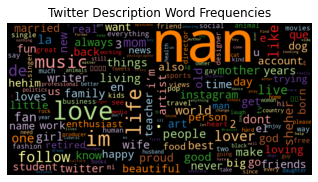

In [258]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(twit_freq['freq'], title = "Twitter Description Word Frequencies")

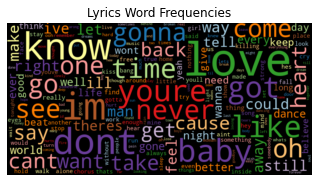

In [260]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(lyric_freq['freq'], title = "Lyrics Word Frequencies")

#### Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: For onr, the twitter data still has some nulls in it with "nan". After that, the words we saw earlier like "love", "life", and "im" are near the largest in size. After these, there are ones like "music", "follow", "lover" and "like" -- which all make sense in a twitter description as these are ways to describe yourself, your interests, and who/what you like to follow.

In the lyrics, there are about 10-15 words seem to be the same size, like "love", "dont", "baby", "oh", "know", "time", "you're", "never" and more. With the lower lexical diversity of the lyrics, along with the nature of songs to repeat choruses and that these are more so pop artists who use more straightforward lyrics, this makes sense that there are a small group of words making up a lot of the corpus.